In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import pandas as pd
import sys
# sys.path.append("..")
# values should be in [0,1] since we deal with ratios of coverage


In [3]:
experiment_rel_path = "/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/PROD/learning/2021-06-08_12h13m06s/PCC_inference_all_placettes.csv"
format_percentage_to_float = lambda x: float(x.replace("%",""))
cols_to_format = ['pred_veg_b', 'pred_sol_nu', 'pred_veg_moy', 'pred_veg_h',
                  'vt_veg_b', 'vt_sol_nu', 'vt_veg_moy', 'vt_veg_h','error_veg_b', 
                  'error_veg_moy', 'error_veg_b_and_moy']
df_input = pd.read_csv(experiment_rel_path, converters={key:format_percentage_to_float for key in cols_to_format})
df_input[["pl_id","vt_veg_b","vt_veg_moy","vt_veg_h"]].head()

,pl_id,vt_veg_b,vt_veg_moy,vt_veg_h
0,2021_POINT_OBS10,0.50,0.25,0.25
1,2021_POINT_OBS19,1.00,0.10,0.00
2,2021_POINT_OBS20,0.75,0.25,0.10
3,2021_POINT_OBS22,1.00,0.00,0.00
4,2021_POINT_OBS35,1.00,0.00,0.00


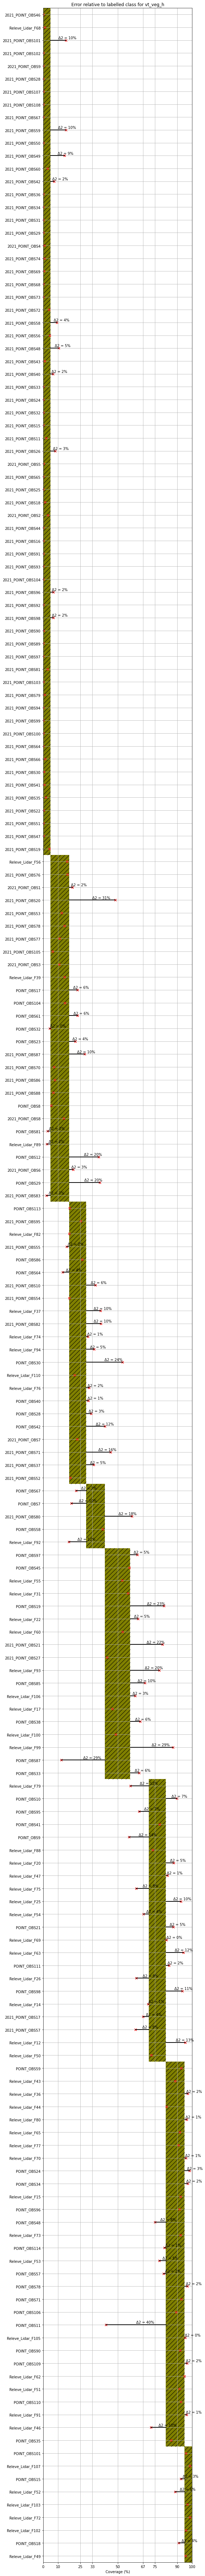

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import numpy as np; np.random.seed(1)
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
bins_borders = np.array([5, 17.5, 29, 41.5, 58.5, 71, 82.5, 95, 100.01]) / 100
bins_centers = np.array([0, 10, 25, 33, 50, 67, 75, 90, 100]) / 100
bb_ = [0] + bins_borders.tolist()
center_to_border_dict = {
    center: borders for center, borders in zip(bins_centers, zip(bb_[:-1], bb_[1:]))
}
#### OUTSIDE

coln = "vt_veg_h"
coln_pred = coln.replace("vt_","pred_")
coln_error2 = coln.replace("vt_","error2_")
sortby_coln = coln

df = df_input.copy().round(3)
df[coln + "_bounds"] = df[coln].apply(lambda c: center_to_border_dict[c])
df[coln + "_class_id"] = df[coln].apply(lambda c: np.argmin(abs(bins_centers - c)))
# df[coln + "_diff"] = df[coln] - df[coln_pred]
df = df.sort_values(sortby_coln, ascending=True).head(1000).reset_index()


output_path = f"./error2_plot_for_{coln}_sortedby_{sortby_coln}"
####


x = np.array([0] + bins_borders.tolist())*100  # TODO: remove *100
y = np.array(range(1,len(df)+2))
X,Y = np.meshgrid(x,y)
Z = np.zeros(shape=(len(y)-1,len(x)-1))
for idx, row in df.iterrows():
    Z[idx,row[coln + "_class_id"]] = 1

# create the colormap
fig, ax = plt.subplots(figsize=(8,len(df)/2))
cMap = ListedColormap(['white', 'olive'])
heatmap = plt.pcolormesh(X,Y,Z, cmap=cMap)

# add hatching
zm = np.ma.masked_less(Z, 0.3)
plt.pcolor(X, Y, zm, hatch='//', alpha=0.)
plt.rc('grid', linestyle="--", color='grey')
ax.grid(True)

#legend of colorbar
# cbar = plt.colorbar(heatmap)
# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(['$N$','$Y$']):
#     cbar.ax.text(.6, (2 * j + 1) /4, lab, ha='center', va='center')
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('Ground truth classes', rotation=270)

for idx, row in df.iterrows():
    x_ = row[coln_pred]*100
    x_gt = row[coln]*100
    bounds = np.array(row[coln+"_bounds"])*100
    x_gt = bounds[np.argmin([abs(x_-bounds[0]), abs(x_-bounds[1])])]
    y_ = idx+1+0.5
    plt.scatter(x_, y_, c="red", marker="x")
    
    error_2 = df[coln_error2].values[idx]
    if error_2>0:
        plt.plot([x_, x_gt], [y_, y_], color='k', linestyle='-', linewidth=2)
        plt.text( (x_+x_gt)/2, y_-0.1, f"Δ2 = {error_2 * 100:.0f}%")

# center xticks and add plot name as ylabels
ax.set_xticks(bins_centers*100, minor=False)
ax.set_yticks(y, minor=False)
ax.set_yticks(y[:-1]+0.5, minor=False)
ax.set_yticklabels(df["pl_id"], minor=False)
plt.title("Error relative to labelled class for " + coln)
plt.xlabel("Coverage (%)")
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(output_path, dpi=200)
plt.show()

## Distribution of actual coverage and of predictions

In [5]:
g = sns.pairplot(
    df,
    x_vars=["vt_veg_b", "vt_veg_moy", "vt_veg_h"],
    y_vars=["vt_veg_b", "vt_veg_moy", "vt_veg_h"],
    diag_kind="hist",
    corner=True,
    height=3,
    diag_kws = {"bins":bb_}
)
g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))
g.map_lower(sns.kdeplot, fill=True, levels=10, clip=[[0, 1], [0, 1]], alpha=0.8)
plt.tight_layout()
g.fig.suptitle("Ground Truths distributions")
plt.savefig("./pairplot_gt.png", dpi=200)

NameError: name 'sns' is not defined

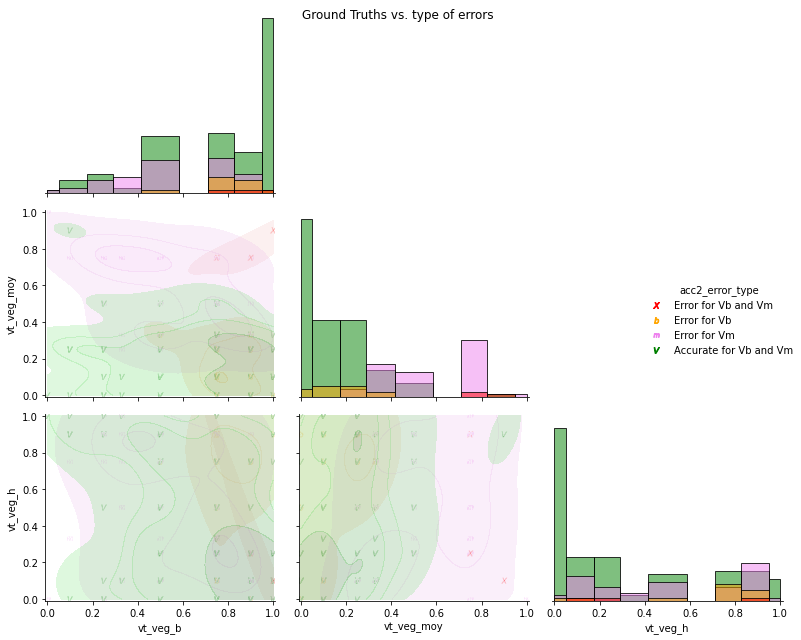

In [10]:
import seaborn as sns
from matplotlib import colors


def get_type_of_error2(acc2_b_m, acc2_b):
    if acc2_b_m == 0:
        return 0  # all fails
    if acc2_b_m == 1:
        return 3  # all good
    if acc2_b == 0:
        return 1  # error is for b
    if acc2_b == 1:
        return 2  # error is for b


df["acc2_error_type"] = df.apply(
    lambda x: get_type_of_error2(x.acc2_veg_b_and_moy, x.acc2_veg_b), axis=1
)
hue_order = [
    "Error for Vb and Vm",
    "Error for Vb",
    "Error for Vm",
    "Accurate for Vb and Vm",
]
mapper = {idx: hue for idx, hue in zip(range(4), hue_order)}
df["acc2_error_type"] = df["acc2_error_type"].replace(mapper)

# noise = (np.random.random(df[["vt_veg_b", "vt_veg_moy", "vt_veg_h"]].values.shape) - 0.5)*0.15
# df[["vt_veg_b", "vt_veg_moy", "vt_veg_h"]] = df[["vt_veg_b", "vt_veg_moy", "vt_veg_h"]] + noise

markers = ["$X$", "$b$", "$m$", "$V$"]
markers = markers[::-1]
palette = ["red", "orange", "violet", "green"]
g = sns.pairplot(
    df,
    x_vars=["vt_veg_b", "vt_veg_moy", "vt_veg_h"],
    y_vars=["vt_veg_b", "vt_veg_moy", "vt_veg_h"],
    hue="acc2_error_type",
    hue_order=hue_order,
    diag_kind="hist",
    corner=True,
    height=3,
    palette=palette,
    markers= markers,
    diag_kws={"bins":bb_, "palette":palette},
)

g.set(xlim=(-0.01, 1.01), ylim=(-0.01, 1.01))
g.map_lower(sns.kdeplot, fill=True, levels=5, color=".2", clip=[[0, 1], [0, 1]], alpha=0.2)

plt.tight_layout()
g.fig.suptitle("Ground Truths vs. type of errors")
plt.savefig("./pairplot_gt_vs_acc2_error_type.png", dpi=200)